# Fig 1-2

We have run the *Monod* inference pipeline on six pre-clustered mouse brain cell glutamatergic subtypes, as well as the entire glutamatergic cell type. In this notebook, we analyze whether the amount of biological variation between the subtypes concords with the amount of biological variation predicted by normalization and mechanistic fit procedures.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()


In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [3]:
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dir_string = './fits/gg_230328_026_allen_celltypes_1'


# Normalization analysis

In [5]:
sd_string = dir_string+'/allen_B08_Glutamatergic/raw.sd'

In [6]:
sd = monod.analysis.load_search_data(sd_string)

In [7]:
#a e s t h e t i c s
fs = 16

In [8]:
from scipy import stats
import copy

Compute the normalization-based CV$^2$ fractions. Note that there are built-in functions for this functionality in *Monod* under `get_noise_decomp`, but for transparency, we do the computations by hand.

In [9]:
S = copy.deepcopy(sd.layers[1])
U = copy.deepcopy(sd.layers[0])

In [10]:
C_S = S.sum(0).mean()
S_PF = S/(S.sum(0)[None,:])*C_S
S_log = np.log(S_PF+1)

In [11]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
pca_transformer.fit(S_log.T)
S_PCA_50D = pca_transformer.transform(S_log.T).T
S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [12]:
S_log.shape

(2951, 5343)

In [13]:
pcat_2 = PCA(n_components = 50)

In [14]:
pcat_2.fit_transform(S_PCA.T).T

array([[-7.47669284e+00, -4.81459014e+00, -7.51500841e+00, ...,
        -4.04547954e+00, -2.61099504e+00,  1.54600877e+00],
       [ 7.26213346e-01, -5.23671982e+00, -1.81934709e-01, ...,
        -4.02689587e+00, -9.84165976e+00, -8.07086520e+00],
       [-3.01343876e+00,  4.82944416e+00, -4.88158778e+00, ...,
         2.45416864e+00, -1.04501166e+00, -7.99417213e-01],
       ...,
       [ 7.39889900e-01, -3.49274580e-01, -1.52778878e-01, ...,
         7.23449431e-01, -2.31889776e-01,  6.77699035e-01],
       [ 1.99643668e-01, -1.80576704e+00, -1.13849560e+00, ...,
         4.02595437e-01,  2.31110852e-01,  3.79519457e-01],
       [ 1.12118058e+00,  2.18449176e+00, -2.68297301e-01, ...,
         8.34327610e-01,  3.13882656e-03, -5.85021143e-01]])

In [15]:
S_PCA_50D

array([[-7.47669284e+00, -4.81459014e+00, -7.51500841e+00, ...,
        -4.04547954e+00, -2.61099504e+00,  1.54600877e+00],
       [ 7.26213346e-01, -5.23671982e+00, -1.81934709e-01, ...,
        -4.02689587e+00, -9.84165976e+00, -8.07086520e+00],
       [-3.01343876e+00,  4.82944416e+00, -4.88158778e+00, ...,
         2.45416864e+00, -1.04501166e+00, -7.99417213e-01],
       ...,
       [ 7.12691143e-01, -2.33999149e-01,  8.34520882e-02, ...,
         6.43501585e-01, -2.81927327e-01,  6.26439134e-01],
       [ 3.04984557e-01, -1.81262214e+00, -1.03221412e+00, ...,
         5.00669294e-01,  2.13075936e-01,  4.10568288e-01],
       [ 1.13730944e+00,  2.20751356e+00, -2.58325843e-01, ...,
         8.61127898e-01,  1.46562805e-03, -5.79946198e-01]])

In [16]:
#this is by far the slowest part.
import umap
umap_transformer = umap.UMAP()
umap_transformer.fit(S_PCA_50D.T)
S_UMAP_2D = umap_transformer.transform(S_PCA_50D.T).T
S_UMAP_50D = umap_transformer.inverse_transform(S_UMAP_2D.T).T
S_UMAP = pca_transformer.inverse_transform(S_UMAP_50D.T).T

Compute the baseline.

In [17]:
dataset_meta = ['B08']
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 
sd_strings = [dir_string + '/' + x + '/raw.sd' for x in dataset_names]

In [18]:
sd_arr = [monod.analysis.load_search_data(x) for x in sd_strings]

In [19]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
pi = n_cells / np.sum(n_cells)

In [20]:
total_mean = S.mean(1)
total_variance = S.var(1)

In [21]:
subtype_means = np.asarray([x.layers[1].mean(1) for x in sd_arr]).T

In [22]:
baseline = (((subtype_means-total_mean[:,None])**2) * pi[None,:]).sum(1) / total_variance

In [23]:
q = np.quantile(total_mean,0.95)
gf = total_mean<q

In [24]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF = S_PF.var(1)/S_PF.mean(1)**2
cv2_log = S_log.var(1)/S_log.mean(1)**2
cv2_PCA = S_PCA.var(1)/S_PCA.mean(1)**2
cv2_UMAP = S_UMAP.var(1)/S_UMAP.mean(1)**2

In [25]:
cv2s = np.asarray([cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP])

Text(0.5, 1.0, 'CV2')

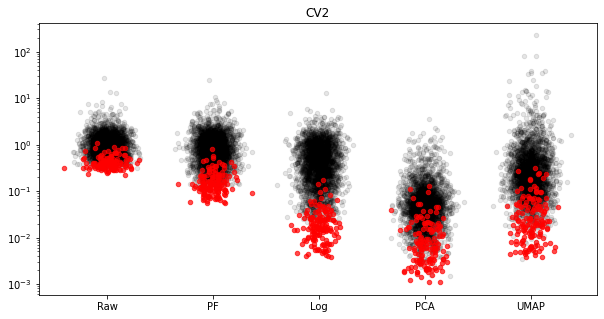

In [26]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2s[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2s[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'])
ax1.set_title('CV2')


In [27]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF_frac = cv2_PF / cv2_raw
cv2_log_frac = cv2_log / cv2_raw
cv2_PCA_frac = cv2_PCA / cv2_raw
cv2_UMAP_frac = cv2_UMAP / cv2_raw

In [28]:
cv2_fracs = np.asarray([cv2_PF_frac,cv2_log_frac,cv2_PCA_frac,cv2_UMAP_frac])

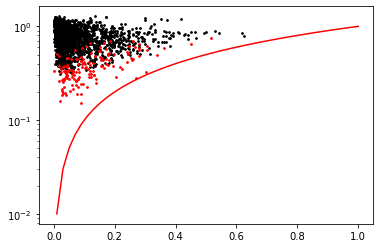

In [29]:
plt.scatter(baseline[gf],cv2_PF_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PF_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

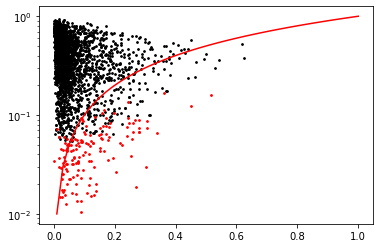

In [30]:
plt.scatter(baseline[gf],cv2_log_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_log_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

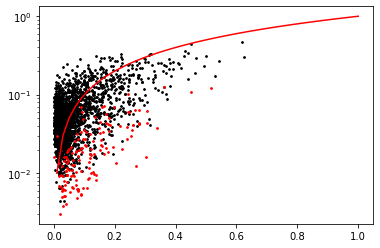

In [31]:
plt.scatter(baseline[gf],cv2_PCA_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PCA_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

(-0.1, 2.0)

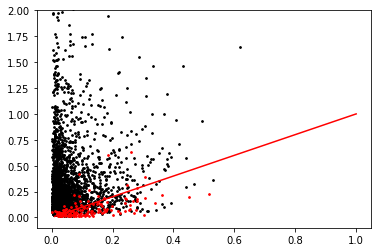

In [32]:
plt.scatter(baseline[gf],cv2_UMAP_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_UMAP_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,2])

# The upshot

In [33]:
import pandas as pd
import loompy as lp
import scipy
from scipy import stats

In [34]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
omitted_subtypes = ('L6 IT Car3','L5 ET')

In [35]:
allen_annot[allen_annot['subclass_label']=='L5 IT']

,cluster_label,subclass_label,class_label,cluster_color,size
cluster_id,,,,,
41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462
42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334
43,L5 IT S100b,L5 IT,Glutamatergic,#00CF1E,4272
44,L5 IT Pld5,L5 IT,Glutamatergic,#00CF1F,653


In [36]:
l5it_clusters = list(allen_annot[allen_annot['subclass_label']=='L5 IT']['cluster_label'])

In [37]:
list(l5it_clusters)

['L5 IT Tcap_1', 'L5 IT Tcap_2', 'L5 IT S100b', 'L5 IT Pld5']

In [38]:
allen_annot[allen_annot['subclass_label']=='L6 CT']

,cluster_label,subclass_label,class_label,cluster_color,size
cluster_id,,,,,
59,L6 CT Gpr139,L6 CT,Glutamatergic,#168577,130
60,L6 CT Cpa6_1,L6 CT,Glutamatergic,#338C5E,5854
61,L6 CT Cpa6_2,L6 CT,Glutamatergic,#409463,5986
62,L6 CT Nxph2 Pou3f2_1,L6 CT,Glutamatergic,#3E766C,268
63,L6 CT Nxph2 Pou3f2_2,L6 CT,Glutamatergic,#488572,535
64,L6 CT Nxph2 Kit,L6 CT,Glutamatergic,#516B78,34


Dataset B08. 
	10975 barcodes in loom, 9216 pass filter. 8424 in annotations; of these, 8424 in loom and 7808 in filtered loom.
	L23IT: 823 cells in annotations. 823 in loom. 823 pass filter.
	L5IT: 2395 cells in annotations. 2395 in loom. 2382 pass filter.
	L6IT: 489 cells in annotations. 489 in loom. 489 pass filter.
	L56NP: 251 cells in annotations. 251 in loom. 250 pass filter.
	L6CT: 1333 cells in annotations. 1333 in loom. 1333 pass filter.
	L6b: 66 cells in annotations. 66 in loom. 66 pass filter.
	Omitted -- L6 IT Car3: 3 cells in annotations. 3 in loom. 3 pass filter.
	Omitted -- L5 ET: 9 cells in annotations. 9 in loom. 9 pass filter.
	Glutamatergic: 5357 cells in annotations. 5357 in loom. 5343 pass filter.
	L5 IT Tcap_1: 626 cells in annotations. 626 in loom. 626 pass filter.
	L5 IT Tcap_2: 1329 cells in annotations. 1329 in loom. 1316 pass filter.
	L5 IT S100b: 386 cells in annotations. 386 in loom. 386 pass filter.
	L5 IT Pld5: 54 cells in annotations. 54 in loom. 54 pass

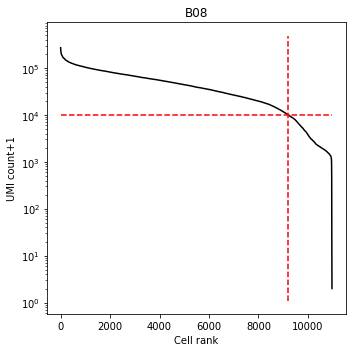

In [39]:
dataset_meta = ['B08']
# 
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [dataset_meta[0] for y in subcluster_names] + [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


cf = []
cf_clus = []
thr_lb = [1e4]*4

fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k + len(subcluster_names)]
    dataset_name = raw_data_locations[len(cluster_names)*k + len(subcluster_names)]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        if k==0:
            for subcluster in subcluster_names:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label'].str.replace(' ','').str.replace('/','')==subcluster) \
                                           & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
                cf.append(np.isin(bcs,annot_bcs) & cf_)
                print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
                
            for subcluster in omitted_subtypes:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label']==subcluster) ]['cell_barcode']
                CF_ = np.isin(bcs,annot_bcs) & cf_
                print(f'\tOmitted -- {subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {CF_.sum()} pass filter.')
        
        for cluster in cluster_names:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
            
            
        for cluster in l5it_clusters:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['cluster_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf_clus.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf_clus[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)
fig1.tight_layout()


In [328]:
np.array(cf_clus).sum(1)

array([ 626, 1316,  386,   54])

In [325]:
subtype_inds

array([   15,   113,   352,   449,   756,   955,  1014,  1387,  1566,
        1585,  1859,  2189,  2237,  2241,  2320,  2449,  2833,  3033,
        3083,  3307,  3346,  3385,  3568,  3794,  3814,  3918,  3995,
        4072,  4303,  4950,  5036,  5896,  5967,  5981,  6161,  6355,
        6375,  6430,  6544,  6749,  6756,  6874,  7084,  7086,  7109,
        7245,  7950,  8242,  8923,  8994,  9038,  9071,  9089,  9449,
        9668,  9710,  9725,  9746,  9760,  9983, 10102, 10139, 10147,
       10182, 10693, 10844])

In [40]:
subtype_filters = np.zeros((6,sum(cf[-1])),dtype=bool)
glu_inds = np.where(cf[-1])[0]
for i in range(6):
    subtype_inds = np.where(cf[i])[0]
    subtype_filters[i] = [ind in subtype_inds for ind in glu_inds]

In [41]:
cluster_filters = np.zeros((4,sum(cf[-1])),dtype=bool)
glu_inds = np.where(cf[-1])[0]
for i in range(4):
    cluster_inds = np.where(cf_clus[i])[0]
    cluster_filters[i] = [ind in cluster_inds for ind in glu_inds]

In [320]:
cluster_filters.sum()

2382

In [321]:
gene_ind_loom = np.where(gene_names == 'Cplx2')[0][0]
# gene_ind_loom = np.where(gene_names == 'Slc30a3')[0][0]

In [322]:
S.shape

(32285, 10975)

In [323]:
S1 = S[gene_ind_loom][cf[1]]
S2 = S[gene_ind_loom][cf[4]]


Text(0.5, 0, '# RNA')

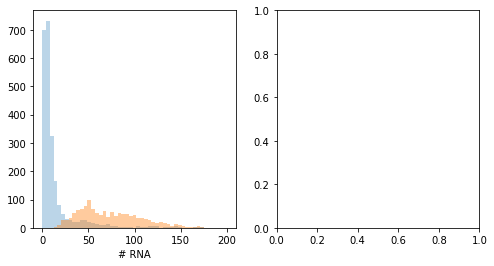

In [324]:
fig1,ax1 = plt.subplots(1,2,figsize=(8,4))
bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')
# ax1[0].hist(Sall,alpha=0.4)

In [311]:
n_cells

array([ 823, 2382,  489,  250, 1333,   66, 5343])

In [312]:
subcluster_names

['L23IT', 'L5IT', 'L6IT', 'L56NP', 'L6CT', 'L6b']

In [313]:
for z in zip(subcluster_names,n_cells):
    print(z)

('L23IT', 823)
('L5IT', 2382)
('L6IT', 489)
('L56NP', 250)
('L6CT', 1333)
('L6b', 66)


In [314]:
c1 = 1
c2 = 4

Illustration: which gene has the highest difference in means between L5IT and L6CT types?

In [315]:
# sorted_genes = np.argsort(np.abs(subtype_means[:,c1]-subtype_means[:,c2]))
# maxind = sorted_genes[-1]
# print(sd.gene_names[maxind])


In [316]:
sorted_genes = np.argsort(cv2_PCA_frac)
# sorted_genes = np.argsort(cv2_UMAP_frac)[:-2]
maxind = sorted_genes[-1]
print(sd.gene_names[maxind])
print(sd.gene_names[sorted_genes[-2:]])

Bcl11b
['Grik3' 'Bcl11b']


In [317]:
# np.abs(subtype_means[maxind,1]-subtype_means[maxind,4])

In [329]:
S1 = sd_arr[1].layers[1,maxind]
S2 = sd_arr[4].layers[1,maxind]
S1 = sd.layers[1,maxind,subtype_filters[1]]
S2 = sd.layers[1,maxind,subtype_filters[4]]
Sall = sd.layers[1,maxind]

In [330]:
S.sum(0)[subtype_filters[1]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10975 but corresponding boolean dimension is 5343

In [331]:
S.shape

(32285, 10975)

In [334]:
S.sum(0).shape

(10975,)

In [337]:
subtype_filters[0].shape

(5343,)

In [332]:
plt.hist(S.sum(0)[subtype_filters[1]],300,alpha=0.3,density=True)
plt.hist(S.sum(0)[subtype_filters[4]],300,alpha=0.3,density=True)
print('hi')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10975 but corresponding boolean dimension is 5343

In [338]:
U.shape

(32285, 10975)

In [339]:
c1

1

IndexError: boolean index did not match indexed array along dimension 1; dimension is 10975 but corresponding boolean dimension is 5343

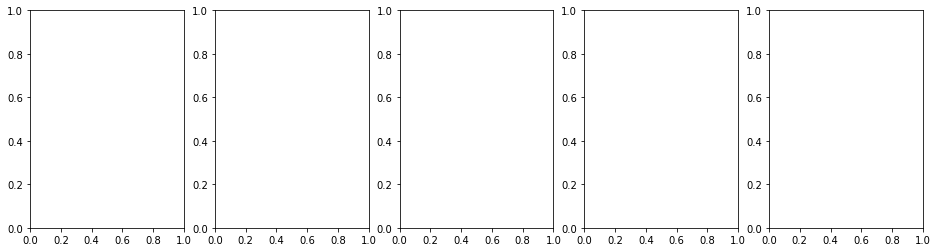

In [340]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[maxind,subtype_filters[c1]]
S2 = S[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')

S1 = S_PF[maxind,subtype_filters[c1]]
S2 = S_PF[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[1].hist(S1,bins,alpha=0.3)
ax1[1].hist(S2,bins,alpha=0.4)
ax1[1].set_xlabel('# RNA')


S1 = S_log[maxind,subtype_filters[c1]]
S2 = S_log[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,10)
ax1[2].hist(S1,bins,alpha=0.3)
ax1[2].hist(S2,bins,alpha=0.4)
ax1[2].set_xlabel('# RNA')


S1 = S_PCA[maxind,subtype_filters[c1]]
S2 = S_PCA[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))



bins = np.linspace(0,10)
ax1[3].hist(S1,bins,alpha=0.3)
ax1[3].hist(S2,bins,alpha=0.4)
ax1[3].set_xlabel('# RNA')


S1 = S_UMAP[maxind,subtype_filters[c1]]
S2 = S_UMAP[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))


bins = np.linspace(0,10)
ax1[4].hist(S1,bins,alpha=0.3)
ax1[4].hist(S2,bins,alpha=0.4)
ax1[4].set_xlabel('# RNA')


In [ ]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[maxind,subtype_filters[c1]]
S2 = S[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')

S1 = S_PF[maxind,subtype_filters[c1]]
S2 = S_PF[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[1].hist(S1,bins,alpha=0.3)
ax1[1].hist(S2,bins,alpha=0.4)
ax1[1].set_xlabel('# RNA')


S1 = S_log[maxind,subtype_filters[c1]]
S2 = S_log[maxind,subtype_filters[c2]]
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[2].hist(S1,bins,alpha=0.3)
ax1[2].hist(S2,bins,alpha=0.4)
ax1[2].set_xlabel('# RNA')


S1 = S_PCA[maxind,subtype_filters[c1]]
S2 = S_PCA[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1

bins = np.linspace(0,200)
ax1[3].hist(S1,bins,alpha=0.3)
ax1[3].hist(S2,bins,alpha=0.4)
ax1[3].set_xlabel('# RNA')


S1 = S_UMAP[maxind,subtype_filters[c1]]
S2 = S_UMAP[maxind,subtype_filters[c2]]
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[4].hist(S1,bins,alpha=0.3)
ax1[4].hist(S2,bins,alpha=0.4)
ax1[4].set_xlabel('# RNA')

fig1.tight_layout()

In [ ]:
top_2 = sorted_genes[-2:]

In [ ]:
S1.shape

In [ ]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[top_2][:,subtype_filters[c1]]
S2 = S[top_2][:,subtype_filters[c2]]

ax1[0].scatter(S1[0],S1[1],alpha=0.2,s=3,label=subcluster_names[c1])
ax1[0].scatter(S2[0],S2[1],alpha=0.2,s=3,label=subcluster_names[c2])
ax1[0].legend()

S1 = S_PF[top_2][:,subtype_filters[c1]]
S2 = S_PF[top_2][:,subtype_filters[c2]]

ax1[1].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[1].scatter(S2[0],S2[1],alpha=0.2,s=3)

S1 = S_log[top_2][:,subtype_filters[c1]]
S2 = S_log[top_2][:,subtype_filters[c2]]

ax1[2].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[2].scatter(S2[0],S2[1],alpha=0.2,s=3)

S1 = S_PCA[top_2][:,subtype_filters[c1]]
S2 = S_PCA[top_2][:,subtype_filters[c2]]

ax1[3].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[3].scatter(S2[0],S2[1],alpha=0.2,s=3)


S1 = S_UMAP[top_2][:,subtype_filters[c1]]
S2 = S_UMAP[top_2][:,subtype_filters[c2]]

ax1[4].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[4].scatter(S2[0],S2[1],alpha=0.2,s=3)

steps = ['Raw','PF','Log','PCA','UMAP']
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel(sd.gene_names[top_2[0]])
    ax.set_ylabel(sd.gene_names[top_2[1]])
fig1.tight_layout()

In [ ]:
S1.shape

In [ ]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S2 = S[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S[top_2][:,cluster_filters[i]]
    ax1[0].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[0].scatter(S2[0],S2[1],alpha=0.2,s=3,label=subcluster_names[c2])
ax1[0].legend()

S2 = S_PF[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_PF[top_2][:,cluster_filters[i]]
    ax1[1].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[1].scatter(S2[0],S2[1],alpha=0.2,s=3)

S2 = S_log[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_log[top_2][:,cluster_filters[i]]
    ax1[2].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[2].scatter(S2[0],S2[1],alpha=0.2,s=3)

S2 = S_PCA[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_PCA[top_2][:,cluster_filters[i]]
    ax1[3].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[3].scatter(S2[0],S2[1],alpha=0.2,s=3)


S2 = S_UMAP[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_UMAP[top_2][:,cluster_filters[i]]
    ax1[4].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[4].scatter(S2[0],S2[1],alpha=0.2,s=3)

steps = ['Raw','PF','Log','PCA','UMAP']
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel(sd.gene_names[top_2[0]])
    ax.set_ylabel(sd.gene_names[top_2[1]])
fig1.tight_layout()

In [ ]:
U.shape

# Correlations between U/S?

In [59]:
SU_corr = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S,U)])


/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [306]:
SU_corr.shape

(32285,)

In [61]:
import sklearn
from sklearn import feature_selection

In [341]:
S[0].shape

(10975,)

In [342]:
S.shape

(32285, 10975)

In [343]:
U.shape


(32285, 10975)

In [66]:
# SU_mut = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y)[0] for x,y in zip(S,U)])


In [ ]:
SU_mut

In [ ]:
SU_mut_disc = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=True)[0] for x,y in zip(S,U)])


In [ ]:
bins = np.linspace(0,.6)
plt.hist(SU_mut,bins,alpha=0.5)
plt.hist(SU_mut_disc,bins,alpha=0.5)

In [122]:
SU_corr_l6 = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S[:,subtype_filters[c2]],U[:,subtype_filters[c2]])])


IndexError: boolean index did not match indexed array along dimension 1; dimension is 10975 but corresponding boolean dimension is 5343

In [69]:
subtype_filters.shape

(6, 5343)

In [ ]:
plt.hist(SU_corr,30,alpha=0.5)
plt.hist(SU_corr_l6,30,alpha=0.5)

In [ ]:
SU_concat = np.concatenate((S,U))

In [ ]:
# S_concat_PF.shape

In [ ]:
C_SU_concat = SU_concat.sum(0).mean()
SU_concat_PF = SU_concat/(SU_concat.sum(0)[None,:])*C_SU_concat
SU_concat_log = np.log(SU_concat_PF+1)

In [ ]:
np.corrcoef(SU_concat).shape

In [ ]:
fig1,ax1=plt.subplots(figsize=(6,6))
plt.imshow(np.corrcoef(SU_concat),vmin=-1,vmax=1,cmap='coolwarm')

In [ ]:
S_concat_PF,U_concat_PF = np.array_split(SU_concat_PF,2,0)
SU_corr_PF = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_PF,U_concat_PF)])

In [ ]:
fig1,ax1=plt.subplots(figsize=(6,6))
plt.imshow(np.corrcoef(SU_concat),vmin=-1,vmax=1,cmap='coolwarm')

In [ ]:
S_concat_log,U_concat_log = np.array_split(SU_concat_log,2,0)
SU_corr_log = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_log,U_concat_log)])

In [ ]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
pca_transformer.fit(SU_concat_log.T)
SU_PCA_50D = pca_transformer.transform(SU_concat_log.T).T
SU_concat_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [ ]:
S_concat_PCA,U_concat_PCA = np.array_split(SU_concat_PCA,2,0)
SU_corr_PCA = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_PCA,U_concat_PCA)])

In [ ]:
SU_concat_PCA.shape

In [ ]:
#this is by far the slowest part.
import umap
umap_transformer = umap.UMAP()
umap_transformer.fit(SU_PCA_50D.T)
SU_UMAP_2D = umap_transformer.transform(SU_PCA_50D.T).T
SU_UMAP_50D = umap_transformer.inverse_transform(SU_UMAP_2D.T).T
SU_concat_UMAP = pca_transformer.inverse_transform(SU_UMAP_50D.T).T

In [ ]:
S_concat_UMAP,U_concat_UMAP = np.array_split(SU_concat_UMAP,2,0)
SU_corr_UMAP = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_UMAP,U_concat_UMAP)])

In [ ]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

ax1[0].hist(SU_corr,30)
ax1[1].hist(SU_corr_PF,30)
ax1[2].hist(SU_corr_log,30)
ax1[3].hist(SU_corr_PCA,30)
ax1[4].hist(SU_corr_UMAP,30)
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel('nas/mat corr')

In [ ]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_corr[gf],SU_corr_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_corr[~gf],SU_corr_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_corr[gf],SU_corr_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_corr[~gf],SU_corr_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_corr[gf],SU_corr_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_corr[~gf],SU_corr_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_corr[gf],SU_corr_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_corr[~gf],SU_corr_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat corr (raw)')
    ax.set_ylabel('nas/mat corr after step')
fig1.tight_layout()

In [708]:
SU_mut_PF = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_PF,U_concat_PF)])


In [709]:
SU_mut_log = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_log,U_concat_log)])


In [712]:
SU_mut_PCA = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_PCA,U_concat_PCA)])


In [715]:
SU_mut_UMAP = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_UMAP,U_concat_UMAP)])


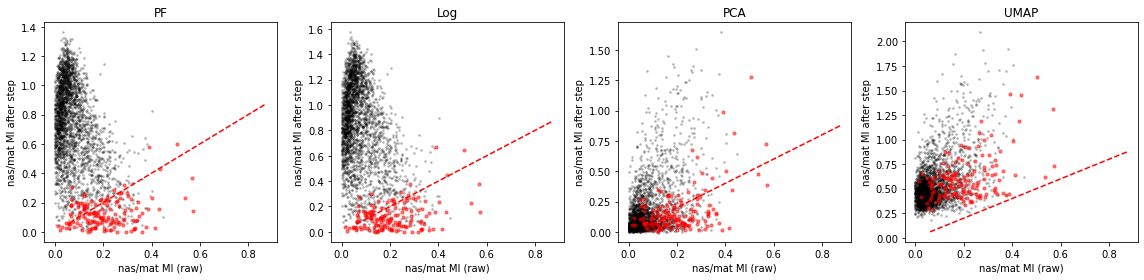

In [731]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_mut[gf],SU_mut_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_mut[~gf],SU_mut_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_mut[gf],SU_mut_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_mut[~gf],SU_mut_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_mut[gf],SU_mut_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_mut[~gf],SU_mut_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_mut[gf],SU_mut_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_mut[~gf],SU_mut_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat MI (raw)')
    ax.set_ylabel('nas/mat MI after step')
fig1.tight_layout()

In [494]:
gf.sum()

2803

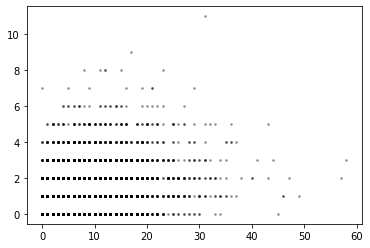

In [334]:
plt.scatter(S[0],S[1],3,'k',alpha=0.3)

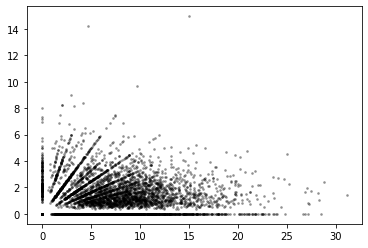

In [335]:
plt.scatter(S_PF[0],S_PF[1],3,'k',alpha=0.3)

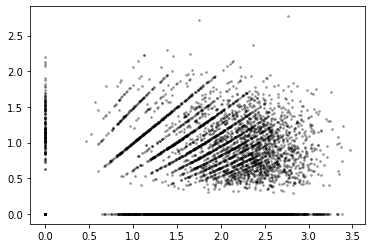

In [226]:
plt.scatter(S_log[0],S_log[1],3,'k',alpha=0.3)

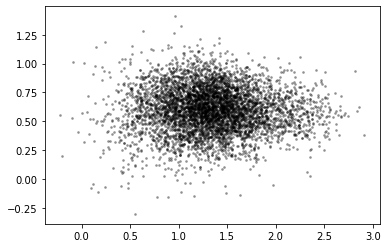

In [227]:
i=10
plt.scatter(S_PCA[i],S_PCA[i+4],3,'k',alpha=0.3)

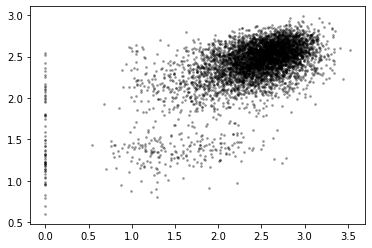

In [245]:
i=700

plt.scatter(S_log[i],S_PCA[i],3,'k',alpha=0.3)

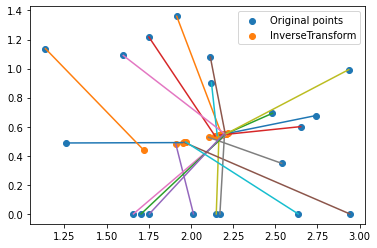

In [261]:
# X_orig = np.random.rand(20, 2)
X_orig = S_log[:,:20].T
pca = PCA(1)
pca.fit(X_orig)
X_transf = pca.transform(X_orig).T
X_re_orig = pca.inverse_transform(X_transf.T)

plt.scatter(X_orig[:, 0], X_orig[:, 1], label='Original points')
plt.scatter(X_re_orig[:, 0], X_re_orig[:, 1], label='InverseTransform')
[plt.plot([X_orig[i, 0], X_re_orig[i, 0]], [X_orig[i, 1], X_re_orig[i, 1]]) for i in range(len(X_orig))]
plt.legend()
plt.show()


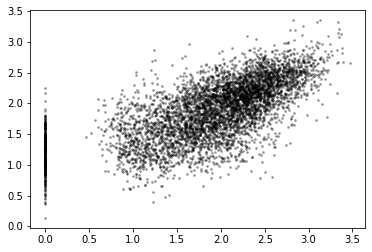

In [250]:
plt.scatter(S_log[0],S_PCA[0],3,'k',alpha=0.3)

In [255]:
# S_PCA.shape

In [256]:
pca_transformer = PCA(n_components=50)
pca_transformer.fit(S_log.T)
# S_PCA_50D = pca_transformer.transform(S_log.T).T
# S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

PCA(n_components=50)

In [220]:
S_PCA.shape

(2951, 5343)

# *Monod*

Perform analysis on mechanistic fit.

In [72]:
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
n_datasets = len(dataset_names)

In [73]:
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [74]:
result_strings

['./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/grid_scan_results_upd.res']

Import results.

In [76]:
opt = []
n_cells = []
sr_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    opt.append(sr.samp_optimum)
    n_cells.append(sr.n_cells)
    sr_arr.append(sr)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [77]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

Where should we set the sampling parameters? The results for low-abundance cell types are questionable. We somewhat arbitrarily set the parameters for all to the glutamatergic result.

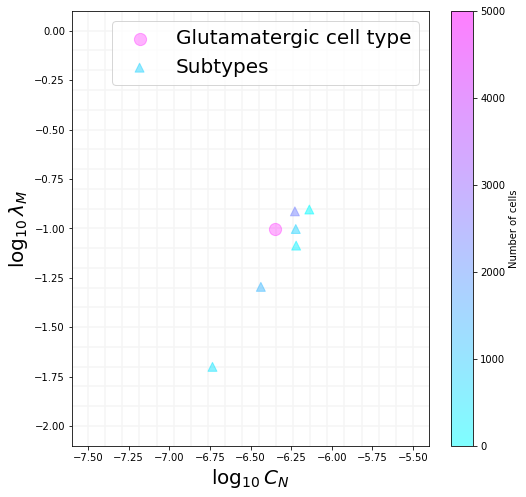

In [78]:
fs = 20

d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.01
opt_ = opt+jit
cmap = 'cool'

ctf = range(6,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],150,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='Glutamatergic cell type',vmin=0,vmax=5000)
stf = range(6)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='Subtypes',vmin=0,vmax=5000)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = './figs/landscape_qc_allen.png'
plt.savefig(fig_string,dpi=450)


For this analysis, we ignore goodness of fit and confidence intervals.

In [82]:
# model_moments.shape

In [83]:
model_moments = []
li = sr_arr[-1].samp_optimum_ind
for j in range(n_datasets-1):

    p = 10**sr_arr[j].param_estimates[li] #b, beta, gamma
    l = 10**sr_arr[j].regressor[li]
    
    p=p.T
    l=l.T
    mu_bio =  p[0]/p[2]
    mu_tech = mu_bio * l[1]
    var_bio = mu_bio*(1+p[0]*p[1]/(p[1]+p[2]))
    var_tech = mu_tech*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
    model_moments.append((mu_bio,mu_tech,var_bio,var_tech))
    
model_moments = np.asarray(model_moments)


In [84]:
mean_bio = (model_moments[:,0,:]*pi[:,None]).sum(0)
var_bio = (model_moments[:,2,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,0,:]-mean_bio)**2)*pi[:,None]).sum(0)

mean_tech = (model_moments[:,1,:]*pi[:,None]).sum(0)
var_tech = (model_moments[:,3,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,1,:]-mean_tech)**2)*pi[:,None]).sum(0)

cv2_bio = var_bio/mean_bio**2
cv2_tech = var_tech/mean_tech**2
cv2_monod_frac = cv2_bio/cv2_tech


(-0.1, 1.0)

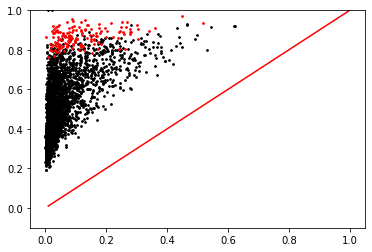

In [85]:
plt.scatter(baseline[gf],cv2_monod_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_monod_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,1])

# Fig 1 b-h

Plot the noise fractions and attributions for the PF, log, PCA, and UMAP.

In [86]:
# a e s t h e t i c s
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 20
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'

0.0
0.08166723144696712
0.35140630294815317
0.09081667231446967


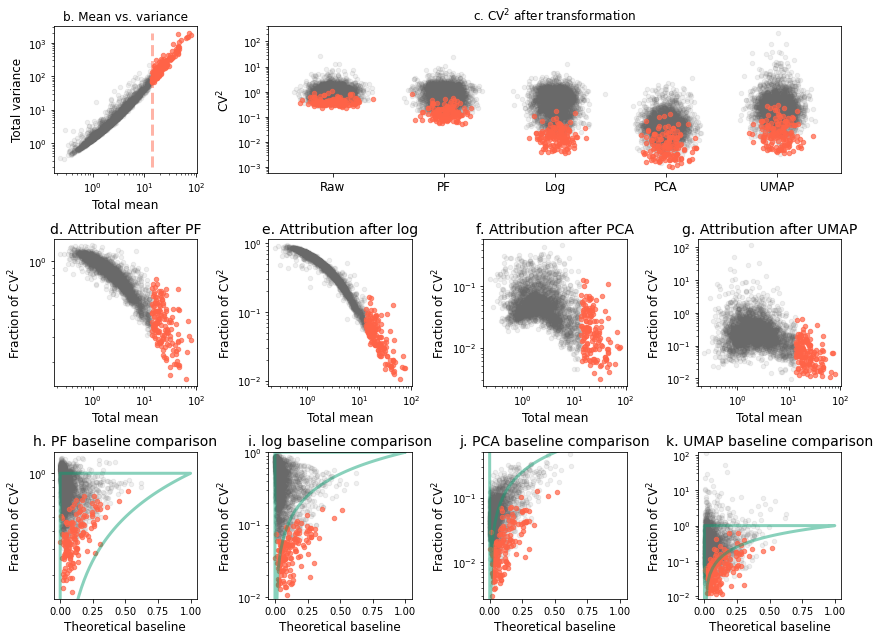

In [87]:
fig1,ax1=plt.subplots(3,4,figsize=(12,9))

fl = 97+1
#mean-variance relationship
ax1[0,0].scatter(total_mean[gf],total_variance[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0,0].scatter(total_mean[~gf],total_variance[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0,0].plot([q]*2,[2e-1,2e3],'--',color=c_highlight,alpha=alpha_line,linewidth=lw)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0,0].set_ylabel('Total variance',fontsize=fs_axes)
ax1[0,0].set_title('{}. Mean vs. variance'.format(chr(fl)))

#cv2
gs = ax1[0,1].get_gridspec()
for ax in ax1[0,1:]:
    ax.remove()
axcv2 = fig1.add_subplot(gs[0,1:])
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    axcv2.scatter(xlocs[gf],cv2s[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    axcv2.scatter(xlocs[~gf],cv2s[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
axcv2.set_yscale('log')
axcv2.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'],fontsize=fs_axes)
axcv2.set_ylabel(r'CV$^2$',fontsize=fs_axes)
axcv2.set_title('{}. CV$^2$ after transformation'.format(chr(fl+1)))

#mean dependence
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(total_mean[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(total_mean[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    ax1[1,k].set_xscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_xlabel('Total mean',fontsize=fs_axes)
    ax1[1,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    ax1[1,k].set_title('{}. Attribution after {}'.format(chr(fl+2+k),names[k]),fontsize=fs_title)

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[2,k].scatter(baseline[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[2,k].scatter(baseline[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    
    
    gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    print(gf_.sum()/len(gf_))
    
    ax1[2,k].set_yscale('log')
    ax1[2,k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[2,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[2,k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[2,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[2,k].set_xticks(np.linspace(0,1,5))
    ax1[2,k].set_title('{}. {} baseline comparison'.format(chr(fl+6+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig1b_k.png',dpi=450)
fig1.savefig('./figs/fig1b_k.pdf')


## Supplement to Fig. 1

Even if UMAP inflates the CV$^2$, how much information have we lost previously in the process?

0.0
0.08166723144696712
0.35140630294815317
0.35547272111148764


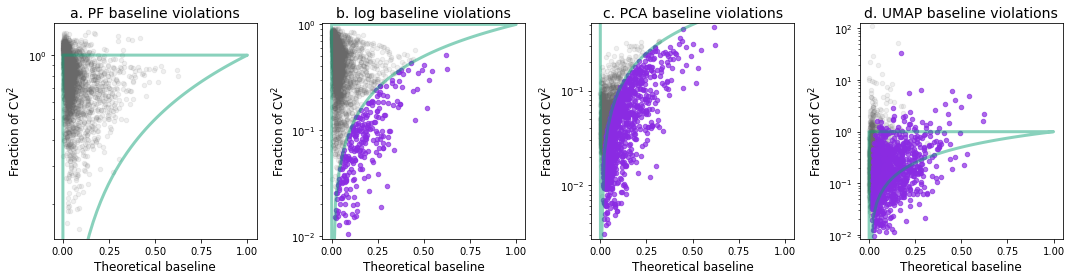

In [88]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    if k==0:
        gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    else:
        gf_ = gf_|(cv2_fracs[k]<baseline)
    print(gf_.sum()/len(gf_))
    ax1[k].scatter(baseline[~gf_],cv2_fracs[k][~gf_],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(baseline[gf_],cv2_fracs[k][gf_],ms_highlight,c_baseline_violation,alpha=alpha_highlight)
    ax1[k].set_yscale('log')
    ax1[k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xticks(np.linspace(0,1,5))
    ax1[k].set_title('{}. {} baseline violations'.format(chr(97+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/baseline_violation.png',dpi=450)
fig1.savefig('./figs/baseline_violation.pdf')


# Fig 2 b-c

How much of the CV$^2$ does a mechanistic approach ascribe to biology?

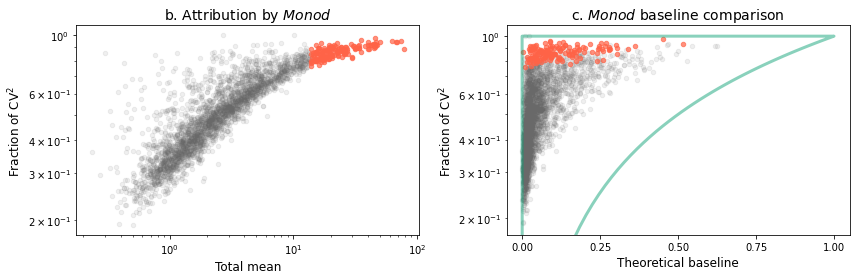

In [89]:
fig1,ax1=plt.subplots(1,2,figsize=(12,4))

# #mean dependence
ax1[0].scatter(total_mean[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0].scatter(total_mean[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1[0].set_title('{}. '.format(chr(97+1))+r'Attribution by $\it{Monod}$',fontsize=fs_title)


ax1[1].scatter(baseline[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[1].scatter(baseline[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1[1].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1[1].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1[1].set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1[1].set_xticks(np.linspace(0,1,5))
ax1[1].set_title('{}. '.format(chr(97+2))+r'$\it{Monod}$ baseline comparison',fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig2bc.png',dpi=450)
fig1.savefig('./figs/fig2bc.pdf')


## Supplements to Fig. 2

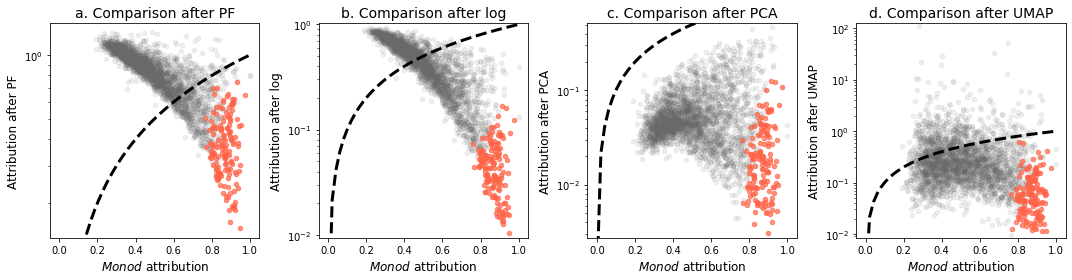

In [90]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[k].scatter(cv2_monod_frac[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(cv2_monod_frac[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[k].set_yscale('log')
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[k].set_title('{}. Comparison after {}'.format(chr(97+k),names[k]),fontsize=fs_title)
fig1.tight_layout()
fig1.savefig('./figs/monod_norm_comparison.png',dpi=450)
fig1.savefig('./figs/monod_norm_comparison.pdf')


What if we fit the entire dataset using *Monod*, without giving the cell type annotations? After all, our aggregation procedure "automatically" applies the law of total variance. It turns out this makes very little difference.

In [91]:
# model_moments = []
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[-1].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[-1].regressor[li]

p=p.T
l=l.T
mu_bio_glu =  p[0]/p[2]
mu_tech_glu = mu_bio_glu * l[1]
var_bio_glu = mu_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
var_tech_glu = mu_tech_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
cv2_bio_glu = var_bio_glu/mu_bio_glu**2
cv2_tech_glu = var_tech_glu/mu_tech_glu**2
cv2_monod_frac_glu = cv2_bio_glu/cv2_tech_glu


In [93]:
# p.sha

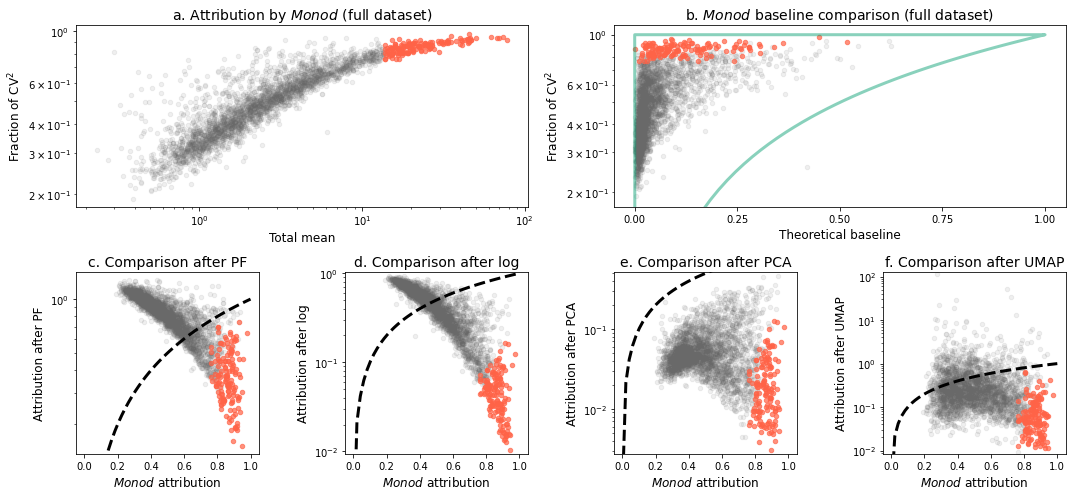

In [94]:
# fig1,ax1=plt.subplots(1,2,figsize=(12,6))
fig1,ax1=plt.subplots(2,4,figsize=(15,7))


gs = ax1[0,0].get_gridspec()
for ax in ax1[0,0:2]:
    ax.remove()
ax1_a = fig1.add_subplot(gs[0,0:2])
ax1_a.scatter(total_mean[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_a.scatter(total_mean[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_a.set_xscale('log')
ax1_a.set_yscale('log')
ax1_a.set_xlabel('Total mean',fontsize=fs_axes)
ax1_a.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1_a.set_title('{}. '.format(chr(97))+r'Attribution by $\it{Monod}$ (full dataset)',fontsize=fs_title)

gs = ax1[0,2].get_gridspec()
for ax in ax1[0,2:]:
    ax.remove()
ax1_b = fig1.add_subplot(gs[0,2:])
ax1_b.scatter(baseline[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_b.scatter(baseline[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_b.set_yscale('log')
ax1_b.set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1_b.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1_b.plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1_b.set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1_b.set_xticks(np.linspace(0,1,5))
ax1_b.set_title('{}. '.format(chr(97+1))+r'$\it{Monod}$ baseline comparison (full dataset)',fontsize=fs_title)

names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(cv2_monod_frac_glu[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(cv2_monod_frac_glu[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[1,k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[1,k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[1,k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[1,k].set_title('{}. Comparison after {}'.format(chr(97+k+2),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/monod_glu.png',dpi=450)
fig1.savefig('./figs/monod_glu.pdf')


# Correlations

In [275]:
p.shape

(3, 2951)

In [276]:
c2 = -1

In [277]:
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[c2].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[c2].regressor[li]

p=p.T
l=l.T

In [278]:
dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b',
 'allen_B08_Glutamatergic']

In [279]:
sd = monod.analysis.load_search_data(sd_strings[c2])

In [280]:
for x in sr_arr:
    x.set_sampling_optimum(li)

In [281]:
_=sr_arr[c2].chisquare_testing(sd,threshold=0.01)

KeyboardInterrupt: 

In [282]:
sr_arr[c2].rejected_genes.sum()

387

In [283]:
sd.layers.shape

(2, 2951, 5343)

In [284]:
SU_corr_l6 = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(sd.layers[0],sd.layers[1])])


In [285]:
SU_corr_l6.shape

(2951,)

In [286]:
cov_nm_bio = p[0]**2/(p[1]+p[2])
mu_n_bio_glu =  p[0]/p[1]
var_n_bio_glu = mu_n_bio_glu*(1+p[0])
mu_m_bio_glu =  p[0]/p[2]
var_m_bio_glu = mu_m_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

In [287]:
corr_nm_bio[sr_arr[c2].rejected_genes]=np.nan

In [288]:
# cov_nm_bio = l[0]*l[1]*p[0]**2/(p[1]+p[2])
# mu_n_bio_glu =  l[0]*p[0]/p[1]
# var_n_bio_glu = mu_n_bio_glu*(1+l[0]*(1+p[0]))
# mu_m_bio_glu =  l[1]*p[0]/p[2]
# var_m_bio_glu = mu_m_bio_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
# corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

(array([   3.,    3.,    0.,   27.,   68.,  154.,  482., 1024.,  714.,
          89.]),
 array([0.27884348, 0.34636394, 0.41388441, 0.48140488, 0.54892535,
        0.61644581, 0.68396628, 0.75148675, 0.81900721, 0.88652768,
        0.95404815]),
 <BarContainer object of 10 artists>)

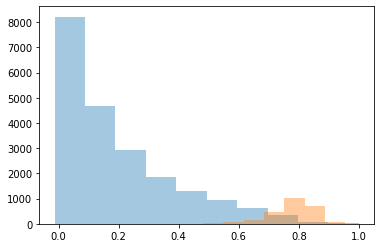

In [289]:
plt.hist(SU_corr,alpha=0.4)
plt.hist(corr_nm_bio,alpha=0.4)

In [290]:
zr = np.log((1+corr_nm_bio)/(1-corr_nm_bio))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
ypos = U_-corr_nm_bio
yneg = corr_nm_bio-L

In [291]:
zr = np.log((1+SU_corr_l6)/(1-SU_corr_l6))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
xpos = U_-SU_corr_l6
xneg = SU_corr_l6-L

In [292]:
(~gf).sum()

148

Text(0, 0.5, 'Predicted biological N/M correlation')

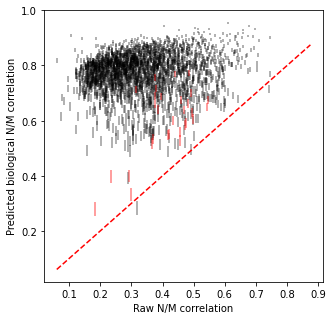

In [293]:
# plt.errorbar(SU_corr_l6,corr_nm_bio,yerr=np.asarray([yneg,ypos]),linestyle='',alpha=0.4,color='k')
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr_l6),max(SU_corr_l6)]
# ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],xerr=np.asarray([xneg[gf],xpos[gf]]),linestyle='',alpha=0.4,color='k')
# ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],xerr=np.asarray([xneg[~gf],xpos[~gf]]),linestyle='',alpha=0.5,color='r')

ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],yerr=np.asarray([yneg[gf],ypos[gf]]),linestyle='',alpha=0.4,color='k')
ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],yerr=np.asarray([yneg[~gf],ypos[~gf]]),linestyle='',alpha=0.5,color='r')
ax1.plot(xl,xl,'r--')

ax1.set_xlabel('Raw N/M correlation')
ax1.set_ylabel('Predicted biological N/M correlation')

In [294]:
sd.gene_names[~gf]

array(['Inpp4a', 'Ptprn', 'Itm2c', 'Epha4', 'Atp1b1', 'Lpgat1', 'Psap',
       'Serinc1', 'Zwint', 'Ank3', 'Spock2', 'Actr2', 'Camk2b', 'Hlf',
       'Sptbn1', 'Rbfox3', 'Nsg2', 'Adcy1', 'Gabra1', 'Ddx5', 'Pafah1b1',
       'Nsf', 'Prkar1a', 'Rtn4', 'Ywhae', 'Cyfip2', 'Mapt', 'Rock2',
       'Myt1l', 'Rtn1', 'Vsnl1', 'Rian', 'Mef2c', 'Cplx2', 'Rgs7bp',
       'Map1b', 'Ntrk2', 'Smim13', 'Ppp3cb', 'Dpysl2', 'Fzd3', 'Mycbp2',
       'Cntn1', 'Ywhaz', 'Arf3', 'Basp1', 'Scn8a', 'Ncald', 'App',
       'Gsk3b', 'Atp6v1a', 'Mapk1', 'Cd47', 'Ttc3', 'Synj1', 'Pja2',
       'Ptprs', 'Slc8a1', 'Prkce', 'Celf4', 'Impact', 'Ndfip1', 'Camk2a',
       'Pura', 'Tcf4', 'Pten', 'Gnaq', 'Rtn3', 'Klf9', 'Gda', 'Ywhab',
       'Kif5c', 'Olfm1', 'Scn2a', 'Nckap1', 'Napb', 'Stxbp1', 'Fam171b',
       'Kcnb1', 'Ndrg3', 'Chn1', 'Dnajc5', 'Dnm1', 'Slc12a5', 'Rasgrp1',
       'Stmn3', 'Prkacb', 'Stmn2', 'Sec62', 'Rap1gds1', 'Atp1a1', 'Ank2',
       'Dclk1', 'Plppr4', 'Gria2', 'Syt11', 'Hpca', 'Kif1b', 'Gnb1',
  

In [295]:
gf_violat = corr_nm_bio<SU_corr_l6

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  5.47016863,   8.74701148,  12.02385433,  15.30069717,
         18.57754002,  21.85438286,  25.13122571,  28.40806855,
         31.6849114 ,  34.96175424,  38.23859709,  41.51543993,
         44.79228278,  48.06912562,  51.34596847,  54.62281132,
         57.89965416,  61.17649701,  64.45333985,  67.7301827 ,
         71.00702554,  74.28386839,  77.56071123,  80.83755408,
         84.11439692,  87.39123977,  90.66808261,  93.94492546,
         97.22176831, 100.49861115, 103.775454  ]),
 <BarContainer object of 30 artists>)

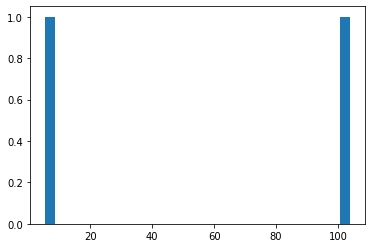

In [296]:
plt.hist(p[0,gf_violat],30)

In [297]:
((~gf)&gf_violat).sum()

0

In [298]:
(corr_nm_bio<SU_corr_l6).sum()

2

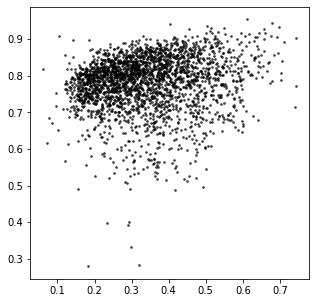

In [299]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6,corr_nm_bio,3,'k',alpha=0.6)
ax1.plot(xl,xl,'r--')


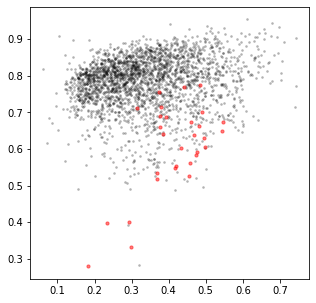

In [300]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6[gf],corr_nm_bio[gf],3,'k',alpha=0.2)
ax1.scatter(SU_corr_l6[~gf],corr_nm_bio[~gf],10,'r',alpha=0.5)
ax1.plot(xl,xl,'r--')


In [304]:
len(SU_corr_l6)

2951

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32285 but corresponding boolean dimension is 2951

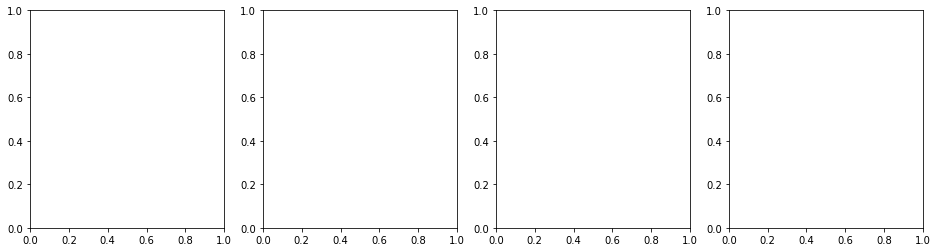

In [301]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_corr[gf],SU_corr_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_corr[~gf],SU_corr_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_corr[gf],SU_corr_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_corr[~gf],SU_corr_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_corr[gf],SU_corr_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_corr[~gf],SU_corr_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_corr[gf],SU_corr_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_corr[~gf],SU_corr_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat corr (raw)')
    ax.set_ylabel('nas/mat corr after step')
fig1.tight_layout()

In [622]:
SU_corr_PCA.shape

(1475,)